In [40]:

import pandas as pd
import pybaseball
pybaseball.cache.enable()
print(pd.__version__)
from pybaseball import statcast
balldata = statcast(start_dt='2025-01-01',end_dt='2025-07-30')
balldata = pd.DataFrame(balldata)
from sklearn.model_selection import train_test_split as tts
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix as cm, classification_report as cr
from collections import Counter
from sklearn.metrics import roc_auc_score

2.3.1
This is a large query, it may take a moment to complete
Skipping offseason dates


100%|██████████| 138/138 [00:07<00:00, 19.65it/s]
/sciclone/home/tdfelton/.conda/envs/baseball2/lib/python3.11/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


In [41]:
player = 'James Wood'
balldata = balldata[balldata['des'].astype(str).str.contains(f"{player}", case=False, na=False)]

In [42]:
# STEP 0: Initial filtering (only regular season games)
balldata = balldata[balldata['game_type'] == 'R'].copy()

# STEP 1: Sort to maintain proper pitch order within at-bats
balldata.sort_values(by=['game_pk', 'at_bat_number', 'pitch_number'], inplace=True)
balldata.reset_index(drop=True, inplace=True)

# STEP 2: Label whether pitch is final pitch of at-bat (Stage 1 target)
balldata['stage1_label'] = (
    balldata.groupby(['game_pk', 'at_bat_number'])['pitch_number'].transform('max') == balldata['pitch_number']
).astype(int)

# STEP 3: Add sequencing features (last 3 pitch types, plate_x, spin rate)
def add_last_n_features(df, col, n=3):
    for i in range(1, n+1):
        df[f'{col}_prev{i}'] = df.groupby(['game_pk', 'at_bat_number'])[col].shift(i)
    return df

balldata = add_last_n_features(balldata, 'pitch_type', 7)
balldata = add_last_n_features(balldata, 'plate_x', 7)
balldata = add_last_n_features(balldata, 'release_spin_rate', 7)
balldata = add_last_n_features(balldata, 'vx0', 7)
balldata = add_last_n_features(balldata, 'plate_z', 7)
balldata = add_last_n_features(balldata, 'vy0', 7)
balldata = add_last_n_features(balldata, 'ax', 7)
balldata = add_last_n_features(balldata, 'release_extension', 7)
balldata = add_last_n_features(balldata, 'az', 7)
balldata = add_last_n_features(balldata, 'release_speed', 7)
balldata = add_last_n_features(balldata, 'release_pos_z', 7)
balldata = add_last_n_features(balldata, 'api_break_x_arm', 7)
balldata = add_last_n_features(balldata, 'effective_speed', 7)
balldata = add_last_n_features(balldata, 'release_pos_y', 7)
balldata = add_last_n_features(balldata, 'spin_axis', 7)
balldata = add_last_n_features(balldata, 'api_break_z_with_gravity', 7)
balldata = add_last_n_features(balldata, 'arm_angle', 7)
balldata = add_last_n_features(balldata, 'release_pos_x', 7)
balldata = add_last_n_features(balldata, 'api_break_x_batter_in', 7)
balldata = add_last_n_features(balldata, 'pfx_z', 7)



# STEP 4: Extract date parts
balldata['game_year'] = pd.to_datetime(balldata['game_date']).dt.year
balldata['game_month'] = pd.to_datetime(balldata['game_date']).dt.month
balldata['game_day'] = pd.to_datetime(balldata['game_date']).dt.day

# STEP 5: Drop unneeded columns
cols_to_drop = [
    'type', 'player_name', 'des', 'home_team', 'game_year', 'away_team', 'game_type',
    'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle', 'hyper_speed',
    'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score', 'bat_win_dif',
    'delta_home_win_exp', 'delta_run_exp', 'delta_pitcher_run_exp', 'bat_score', 'fld_score',
    'home_score_diff', 'home_win_exp', 'on_3b', 'on_2b', 'on_1b', 'pitch_name', 'home_score', 'away_score', 'description',
    'hit_location', 'bb_type', 'hc_x', 'hc_y', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'batter',
    'stand', 'game_pk', 'bat_speed', 'swing_length', 'bat_score_diff', 'bat_win_exp', 'attack_angle', 'attack_direction', 'swing_path_tilt',
    'age_bat', 'zone', 'intercept_ball_minus_batter_pos_x_inches', 'intercept_ball_minus_batter_pos_y_inches'
]

In [43]:
X_stage1 = balldata.drop(columns=['events'], errors='ignore')
X_stage1 = X_stage1.drop(columns=[col for col in X_stage1.columns if 'depreciated' in col or 'legacy' in col or 'estimated' in col])
X_stage1 = X_stage1.drop(columns=[col for col in cols_to_drop if col in X_stage1.columns])

# STEP 6: Set up categorical features for CatBoost
categorical_cols = [
    'game_month', 'pitch_type', 'pitcher', 'p_throws',
    'balls', 'strikes', 'inning', 'fielder_2', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
    'fielder_7', 'fielder_8', 'fielder_9', 'pitch_number', 'at_bat_number',
    'if_fielding_alignment', 'of_fielding_alignment', 'age_pit', 'n_thruorder_pitcher',
    'n_priorpa_thisgame_player_at_bat', 'pitcher_days_since_prev_game', 'batter_days_since_prev_game',
    'pitcher_days_until_next_game', 'batter_days_until_next_game', 'inning_topbot',
    'pitch_type_prev1', 'pitch_type_prev2', 'pitch_type_prev3'
]
pitch_type_prev_cols = [col for col in X_stage1.columns if col.startswith('pitch_type_prev')]
categorical_cols = list(set(categorical_cols + pitch_type_prev_cols))

X_stage1[categorical_cols] = X_stage1[categorical_cols].astype(str)

# STEP 7: Assign target
y_stage1 = balldata['stage1_label']
X_stage1 = X_stage1.drop(columns='stage1_label')
X_stage1[categorical_cols] = X_stage1[categorical_cols].fillna("MISSING")
X_stage1.fillna(-999, inplace=True)

The below code is kind of useless unless I'm doing live analysis, did it more so to practice on a more complete dataset before moving to the full batting average predictor

In [44]:
x_train1, x_test1, y_train1, y_test1 = tts(X_stage1, y_stage1, test_size=0.2, stratify=y_stage1)

#class_counts = Counter(y_train1)
#total = sum(class_counts.values())
#class_weights = {cls: total/count for cls, count in class_counts.items()}
#print("Class weights:", class_weights)

model_stage1 = CatBoostClassifier(
    verbose=100,
    scale_pos_weight=2.0,
    eval_metric='F1',
)

model_stage1.fit(x_train1, y_train1, eval_set = (x_test1, y_test1), early_stopping_rounds = 50, cat_features=categorical_cols)

y_pred1 = model_stage1.predict(x_test1)
print(cm(y_test1, y_pred1))
print(cr(y_test1, y_pred1, digits=3))

Learning rate set to 0.041123
0:	learn: 0.5794393	test: 0.5652842	best: 0.5652842 (0)	total: 20.5ms	remaining: 20.5s
100:	learn: 0.8878808	test: 0.8597169	best: 0.8630491 (92)	total: 1.64s	remaining: 14.6s
200:	learn: 0.9323017	test: 0.8877805	best: 0.8927681 (184)	total: 3.27s	remaining: 13s
300:	learn: 0.9572539	test: 0.8938272	best: 0.8993789 (252)	total: 4.91s	remaining: 11.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.899378882
bestIteration = 252

Shrink model to first 253 iterations.
[[465  65]
 [  8 181]]
              precision    recall  f1-score   support

           0      0.983     0.877     0.927       530
           1      0.736     0.958     0.832       189

    accuracy                          0.898       719
   macro avg      0.859     0.918     0.880       719
weighted avg      0.918     0.898     0.902       719



In [45]:
final_pitches = balldata[balldata['stage1_label'] == 1].copy()
hit_events = ['single', 'double', 'triple', 'home_run']
final_pitches['stage2_label'] = final_pitches['events'].isin(hit_events).astype(int)
X_stage2 = final_pitches.drop(columns=['stage2_label', 'events'], errors='ignore')
X_stage2 = X_stage2.drop(columns=[col for col in X_stage2.columns if 'depreciated' in col or 'legacy' in col or 'estimated' in col])
X_stage2 = X_stage2.drop(columns=[col for col in cols_to_drop if col in X_stage2.columns])

X_stage2[categorical_cols] = X_stage2[categorical_cols].astype(str)
X_stage2[categorical_cols] = X_stage2[categorical_cols].fillna("MISSING")
X_stage2.fillna(-999, inplace=True)

y_stage2 = final_pitches['stage2_label']

In [46]:
x_train2, x_test2, y_train2, y_test2 = tts(X_stage2, y_stage2, test_size=0.2, stratify=y_stage2)

model_stage2 = CatBoostClassifier(
    verbose=100,
    scale_pos_weight=(len(y_train2) - sum(y_train2)) / sum(y_train2),
    eval_metric='F1',
)

model_stage2.fit(x_train2, y_train2, cat_features=categorical_cols)

y_pred2 = model_stage2.predict(x_test2)
print(cm(y_test2, y_pred2))
print(cr(y_test2, y_pred2, digits=3))


Learning rate set to 0.009127
0:	learn: 0.6975647	total: 16.5ms	remaining: 16.5s
100:	learn: 0.7727538	total: 1.47s	remaining: 13.1s
200:	learn: 0.7935808	total: 2.95s	remaining: 11.7s
300:	learn: 0.8232588	total: 4.43s	remaining: 10.3s
400:	learn: 0.8550167	total: 5.88s	remaining: 8.79s
500:	learn: 0.8858292	total: 7.36s	remaining: 7.33s
600:	learn: 0.9101449	total: 8.82s	remaining: 5.85s
700:	learn: 0.9256228	total: 10.3s	remaining: 4.38s
800:	learn: 0.9431857	total: 11.8s	remaining: 2.92s
900:	learn: 0.9602446	total: 13.2s	remaining: 1.45s
999:	learn: 0.9661538	total: 14.7s	remaining: 0us
[[81 37]
 [31 40]]
              precision    recall  f1-score   support

           0      0.723     0.686     0.704       118
           1      0.519     0.563     0.541        71

    accuracy                          0.640       189
   macro avg      0.621     0.625     0.622       189
weighted avg      0.647     0.640     0.643       189



In [54]:
importances = model_stage2.get_feature_importance()
features = X_stage2.columns
imp_df = pd.DataFrame({ "Feature": features, "Importance": importances })

# Step 3: Select top N features
top_features = imp_df.sort_values(by="Importance", ascending=False)["Feature"].head(50).tolist()
cat_top = [col for col in top_features if col in categorical_cols]

# Step 4: Subset and retrain with only top features
X_top = X_stage2[top_features]
x_train2, x_test2, y_train2, y_test2 = tts(X_top, y_stage2, test_size=0.2, stratify=y_stage2)

filtered_model = CatBoostClassifier(
    verbose=100,
    scale_pos_weight=(len(y_train2) - sum(y_train2)) / sum(y_train2),
    eval_metric='F1',
    early_stopping_rounds=50
)
filtered_model.fit(x_train2, y_train2, cat_features=cat_top)

# Step 5: Evaluate
from sklearn.metrics import roc_auc_score

# Get predicted probabilities for class 1
y_probs2 = filtered_model.predict_proba(x_test2)[:, 1]

# Apply confidence threshold (tune this value!)
threshold = 0.52
y_pred2 = (y_probs2 > threshold).astype(int)

# Evaluate
print(f"Threshold used: {threshold}")
print(cm(y_test2, y_pred2))
print(cr(y_test2, y_pred2, digits=3))

# Optional: AUC (overall classifier quality)
auc = roc_auc_score(y_test2, y_probs2)
print(f"AUC: {auc:.3f}")

Learning rate set to 0.009127
0:	learn: 0.6731308	total: 17.9ms	remaining: 17.9s
100:	learn: 0.7591356	total: 1.33s	remaining: 11.8s
200:	learn: 0.7970053	total: 2.67s	remaining: 10.6s
300:	learn: 0.8279477	total: 3.99s	remaining: 9.26s
400:	learn: 0.8484385	total: 5.35s	remaining: 8s
500:	learn: 0.8713464	total: 6.69s	remaining: 6.67s
600:	learn: 0.9037136	total: 8.04s	remaining: 5.34s
700:	learn: 0.9166198	total: 9.41s	remaining: 4.01s
800:	learn: 0.9325646	total: 10.8s	remaining: 2.69s
900:	learn: 0.9516305	total: 12.2s	remaining: 1.34s
999:	learn: 0.9653716	total: 13.6s	remaining: 0us
Threshold used: 0.52
[[68 50]
 [28 43]]
              precision    recall  f1-score   support

           0      0.708     0.576     0.636       118
           1      0.462     0.606     0.524        71

    accuracy                          0.587       189
   macro avg      0.585     0.591     0.580       189
weighted avg      0.616     0.587     0.594       189

AUC: 0.622


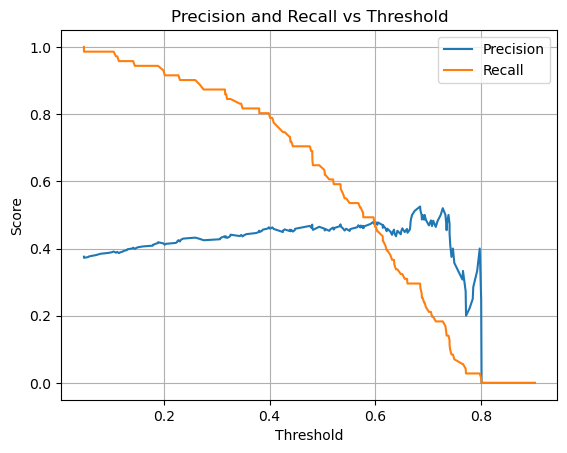

In [55]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precisions, recalls, thresholds = precision_recall_curve(y_test2, y_probs2)

plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

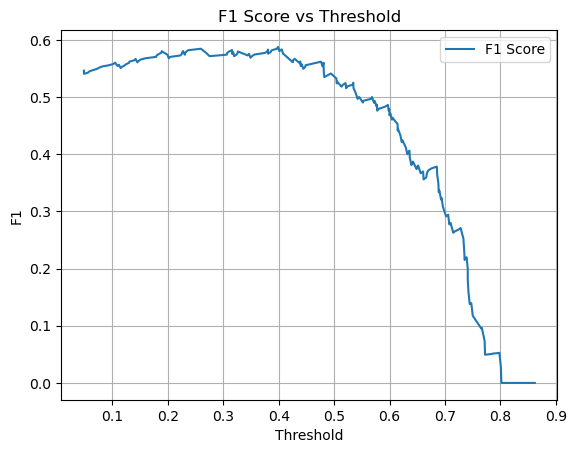

In [56]:
from sklearn.metrics import f1_score

f1s = [f1_score(y_test2, y_probs2 >= t) for t in thresholds[:-1]]

plt.plot(thresholds[:-1], f1s, label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.title("F1 Score vs Threshold")
plt.grid(True)
plt.legend()
plt.show()


From these 2 plots, I've determined that the best threshold for maximizing precision/recall and F1 score is 0.5
This is specifically for Garcia

In [58]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1s = []

for train_idx, test_idx in skf.split(x_train2, y_train2):
    X_train, X_test = x_train2.iloc[train_idx], x_train2.iloc[test_idx]
    y_train, y_test = y_train2.iloc[train_idx], y_train2.iloc[test_idx]

    model = CatBoostClassifier(
        verbose=0,
        scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
        eval_metric='F1',
        early_stopping_rounds=50
    )
    
    model.fit(X_train, y_train, cat_features=cat_top)

    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.52).astype(int)

    f1s.append(f1_score(y_test, y_pred))

print("Mean F1 across folds:", np.mean(f1s))


Mean F1 across folds: 0.543154630845007


In [ ]:
from itertools import product
from joblib import Parallel, delayed
from tqdm import tqdm

# --------------------------
# Inputs
# --------------------------
X = X_stage2.copy()
y = y_stage2.copy()
X[categorical_cols] = X[categorical_cols].astype(str)

# Get feature importances
base_model = CatBoostClassifier(verbose=0)
base_model.fit(X, y, cat_features=categorical_cols)
importances = base_model.get_feature_importance()
features = X.columns
imp_df = pd.DataFrame({ "Feature": features, "Importance": importances })

# --------------------------
# Grid Parameters (linspace)
# --------------------------
top_N_list = np.linspace(10, 150, num=25, dtype=int)
scale_pos_weights = np.linspace(1.0, 10.0, num=15)
early_stops = np.linspace(10, 200, num=10, dtype=int)
thresholds = np.linspace(0.4, 0.6, num=25)

param_grid = list(product(top_N_list, scale_pos_weights, early_stops, thresholds))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --------------------------
# Parallel Evaluation Function
# --------------------------
def evaluate_combo(top_N, scale_wt, esr, thresh):
    top_features = imp_df.sort_values(by="Importance", ascending=False)["Feature"].head(top_N).tolist()
    cat_top = [col for col in top_features if col in categorical_cols]
    X_subset = X[top_features]

    fold_f1s = []

    for train_idx, test_idx in skf.split(X_subset, y):
        X_train, X_test = X_subset.iloc[train_idx], X_subset.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = CatBoostClassifier(
            verbose=0,
            scale_pos_weight=scale_wt,
            eval_metric='F1',
            early_stopping_rounds=esr
        )
        model.fit(X_train, y_train, cat_features=cat_top)

        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob > thresh).astype(int)
        f1 = f1_score(y_test, y_pred)
        fold_f1s.append(f1)

    return {
        'top_N': top_N,
        'scale_pos_weight': scale_wt,
        'early_stopping_rounds': esr,
        'threshold': thresh,
        'mean_f1': np.mean(fold_f1s)
    }

# --------------------------
# Run in Parallel
# --------------------------
results = Parallel(n_jobs=-1)(
    delayed(evaluate_combo)(top_N, scale_wt, esr, thresh)
    for (top_N, scale_wt, esr, thresh) in tqdm(param_grid)
)

# --------------------------
# Results Summary
# --------------------------
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='mean_f1', ascending=False)
print(results_df.head(10))

In [59]:
X_stage2.to_pickle("X_stage2.pkl")
y_stage2.to_pickle("y_stage2.pkl")
imp_df.to_pickle("feature_importances.pkl")
with open("categorical_cols.pkl", "wb") as f:
    import pickle
    pickle.dump(categorical_cols, f)